In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import sklearn
import matplotlib.pyplot as plt
import gc # для gc.collect()
import seaborn as sns

cwd = r'C:\Projects\ODS_Avito_hack'
os.chdir(cwd)
os.getcwd()

'C:\\Projects\\ODS_Avito_hack'

In [2]:
# Source 
train_data = cwd + r'\train.parquet'
test_data = cwd + r'\test.parquet.parquet'
categories_data = cwd + r'\categories.parquet.csv.parquet' # данные о логических категориях
campaigns_data = cwd + r'\campaigns_meta.parquet.parquet' # данные о рекламных кампаниях

# Загрузка данных с указанием batch_size (не используется)
train_pq = pq.ParquetFile(train_data)
# обычный способ
train = pd.read_parquet(train_data) 
test = pd.read_parquet(test_data)
categories = pd.read_parquet(categories_data)
campaigns = pd.read_parquet(campaigns_data)

In [11]:
# Бейзлайн от Авито - если пользователь уже видел рекламу и кликнул на нее, то он снова сделает клик. Если же реклама была показана, но клик не последовал, то и в следующий раз клик маловероятен.
user_ads_clicks = train.groupby(["user_id", "adv_campaign_id"], as_index=False)["target"].max()
test = test.merge(user_ads_clicks, on=["user_id", "adv_campaign_id"], how="left")
test["predict"] = test["target"].fillna(0.5)
test[["user_id", "adv_campaign_id", "predict"]].to_csv("sample_submission.csv", index=False)


In [51]:
 #|-- platform_id: id платформы (Android, Ios и т.п.)
 #|-- user_id: id Пользователя 
 #|-- adv_campaign_id: id рекламной компании 
 #|-- target: клик / не клик
 #|-- banner_code: код баннера
 #|-- adv_creative_id: индификатор креатива
 #|-- event_date: date Дата показа рекламной кампании пользователю
 #|-- is_main: boolean True - показ рекламы был осуществлен с главной страницы

print(train.info())
print('**********************************')
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int64 
 1   adv_campaign_id  int64 
 2   platform_id      int64 
 3   adv_creative_id  int64 
 4   event_date       object
 5   banner_code      int64 
 6   is_main          bool  
 7   target           int32 
dtypes: bool(1), int32(1), int64(5), object(1)
memory usage: 5.7+ GB
None
**********************************
   user_id  adv_campaign_id  platform_id  adv_creative_id  event_date  \
0  2853707             3352            3             3075  2024-09-17   
1  2537244             4029            2             3260  2024-09-17   
2    63033             1578            3             1109  2024-09-17   
3   164702             3434            1             1079  2024-09-17   
4  2802905             2208            3             3576  2024-09-17   

   banner_code  is_main  target  
0           

In [4]:
###### ДОРАБОТКИ, НОРМАЛИЗАЦИЯ TRAIN ###########
train['event_date']=pd.to_datetime(train['event_date']) # преобразовали в дату
train["target"] = train['target'].astype(bool)
train["platform_id"] = train['platform_id'].astype('int8')
train["adv_campaign_id"] = train['adv_campaign_id'].astype('int16')
train["adv_creative_id"] = train['adv_creative_id'].astype('int16')
train["banner_code"] = train['banner_code'].astype('int8')
train["user_id"] = train['user_id'].astype('int32')

In [97]:
print(train.info())
print('**********************************')
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int32         
 1   adv_campaign_id  int16         
 2   platform_id      int8          
 3   adv_creative_id  int16         
 4   event_date       datetime64[ns]
 5   banner_code      int8          
 6   is_main          bool          
 7   target           bool          
dtypes: bool(2), datetime64[ns](1), int16(2), int32(1), int8(2)
memory usage: 2.1 GB
None
**********************************
   user_id  adv_campaign_id  platform_id  adv_creative_id event_date  \
0  2853707             3352            3             3075 2024-09-17   
1  2537244             4029            2             3260 2024-09-17   
2    63033             1578            3             1109 2024-09-17   
3   164702             3434            1             1079 2024-09-17   
4  2802905             2208  

In [7]:
print(train.describe())

            user_id  adv_campaign_id   platform_id  adv_creative_id  \
count  1.147410e+08     1.147410e+08  1.147410e+08     1.147410e+08   
mean   1.631755e+06     2.075551e+03  2.247107e+00     2.172110e+03   
min    1.000000e+00     1.000000e+00  1.000000e+00     1.000000e+00   
25%    8.159940e+05     1.081000e+03  2.000000e+00     1.059000e+03   
50%    1.630685e+06     2.117000e+03  2.000000e+00     2.191000e+03   
75%    2.447811e+06     3.044000e+03  3.000000e+00     3.263000e+03   
max    3.263622e+06     4.200000e+03  4.000000e+00     4.302000e+03   
std    9.420017e+05     1.193715e+03  5.831793e-01     1.252162e+03   

                          event_date   banner_code  
count                      114741035  1.147410e+08  
mean   2024-09-14 04:21:21.299477760  7.098832e+00  
min              2024-09-01 00:00:00  1.000000e+00  
25%              2024-09-11 00:00:00  6.000000e+00  
50%              2024-09-15 00:00:00  8.000000e+00  
75%              2024-09-19 00:00:00  8.00

In [9]:
# Проверка типов
print(train['user_id'].min())
print(train['user_id'].max())
# print(sorted(train['user_id'].unique()))

1
3263622


In [30]:
print(train.isnull().sum())

user_id            0
adv_campaign_id    0
platform_id        0
adv_creative_id    0
event_date         0
banner_code        0
is_main            0
target             0
dtype: int64


In [11]:
print(train['target'].value_counts(normalize=True))

target
False    0.99463
True     0.00537
Name: proportion, dtype: float64


                  user_id  adv_campaign_id  platform_id  adv_creative_id  \
user_id          1.000000         0.000245     0.001500        -0.000136   
adv_campaign_id  0.000245         1.000000    -0.005439         0.014144   
platform_id      0.001500        -0.005439     1.000000         0.003247   
adv_creative_id -0.000136         0.014144     0.003247         1.000000   
event_date      -0.000360         0.021205    -0.009016        -0.005474   
banner_code     -0.000742         0.002935    -0.612264        -0.007801   
is_main          0.000354        -0.001313    -0.054624        -0.006872   
target           0.000007         0.000171    -0.009822        -0.001688   

                 event_date  banner_code   is_main    target  
user_id           -0.000360    -0.000742  0.000354  0.000007  
adv_campaign_id    0.021205     0.002935 -0.001313  0.000171  
platform_id       -0.009016    -0.612264 -0.054624 -0.009822  
adv_creative_id   -0.005474    -0.007801 -0.006872 -0.001688  


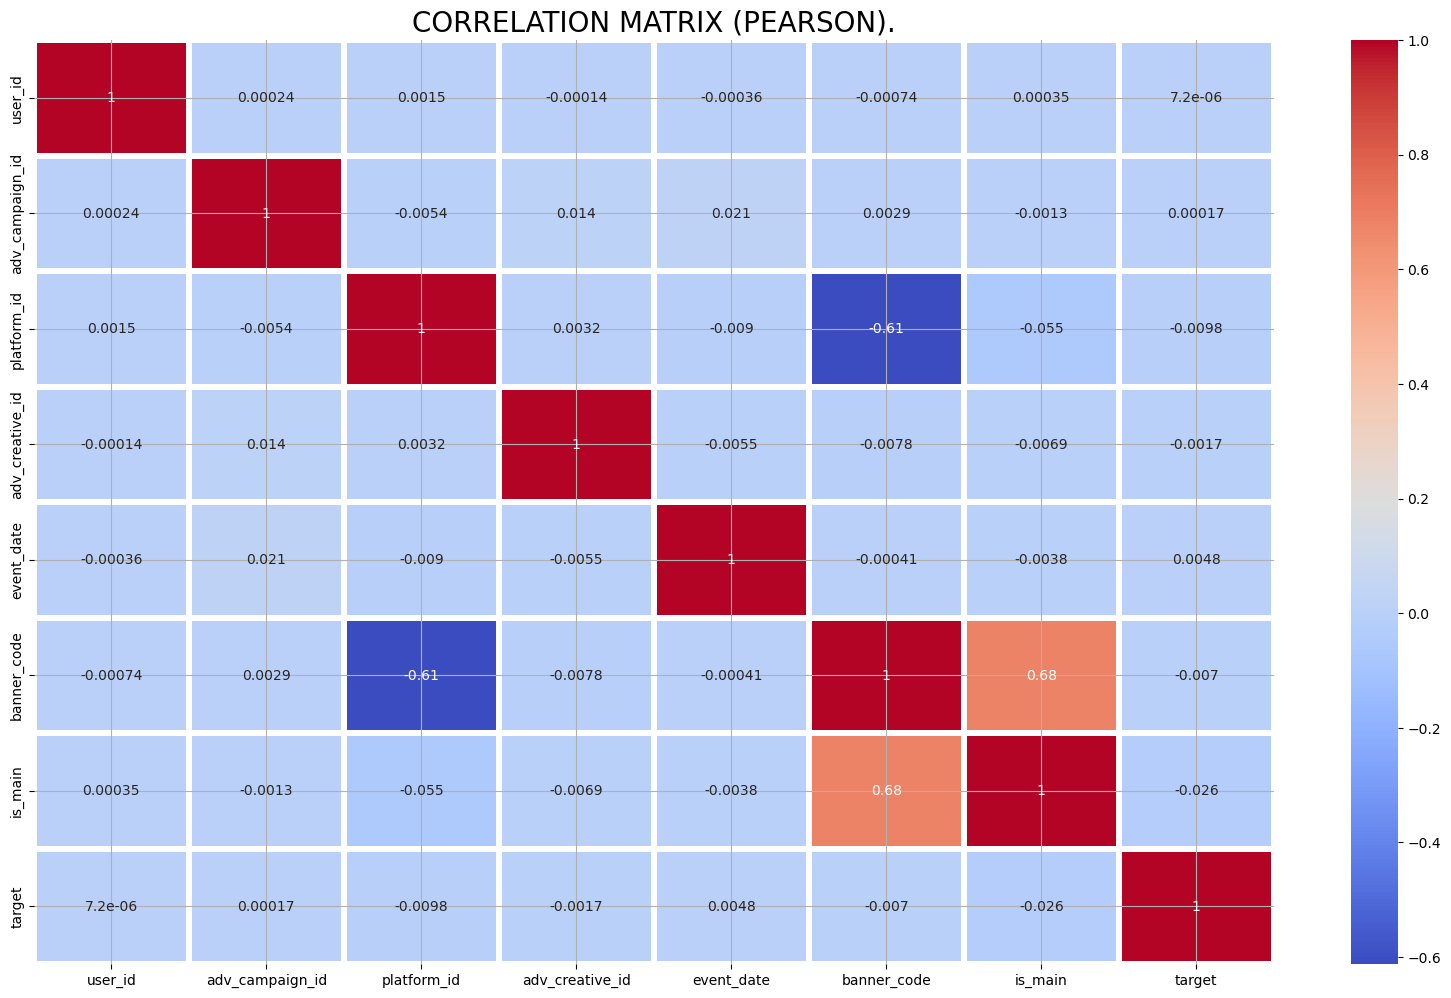

In [33]:
# Корреляционная матрица (Пирсон)
correlation_matrix = train.corr()
print(correlation_matrix)

fig, ax = plt.subplots(figsize=(20,12))
plt.title('CORRELATION MATRIX (PEARSON).', fontsize=20)
sns.heatmap(train.corr(), annot=True, cmap="coolwarm",  fmt='.2g', linewidth=4)
plt.grid(True);

In [13]:
#|-- microcat_id: id микрокатегории 
#|-- level_id: id уровня в дереве микрокатегорий
#|-- parent_microcat_id: id родительской микрокатегории
#|-- logcat_id: id логической категории 
#|-- vertical_id: id вертикали 
#|-- category_id: id категории 

print(categories.head())
print('**********************************')
print(categories.describe())
print('**********************************')
print(categories.isnull().sum())
print('**********************************')
print(categories.info())

   microcat_id  level_id  parent_microcat_id  logcat_id  vertical_id  \
0        33482       7.0             40172.0       54.0          3.0   
1        27254       5.0             48637.0       55.0          5.0   
2        37005       6.0             15332.0       54.0          3.0   
3        31376       8.0             28137.0       58.0          8.0   
4        20493       4.0             18343.0       24.0          8.0   

   category_id  
0          3.0  
1          4.0  
2          3.0  
3          4.0  
4          9.0  
**********************************
        microcat_id      level_id  parent_microcat_id     logcat_id  \
count  25891.000000  25890.000000        25888.000000  25883.000000   
mean   25094.792438      6.021514        25007.398061     33.397867   
std    14417.501552      0.887269        14519.892783     18.233059   
min        3.000000      1.000000           12.000000      1.000000   
25%    12599.000000      5.000000        12272.000000     18.000000   
50% 

In [17]:
# Показать все строки, где есть хотя бы одно значение NaN
rows_with_nulls = categories[categories.isnull().any(axis=1)]

# Вывести эти строки
print(rows_with_nulls)

       microcat_id  level_id  parent_microcat_id  logcat_id  vertical_id  \
6515         29041       1.0             46844.0        NaN          NaN   
16855        46844       NaN                 NaN        NaN          NaN   
16981        36108       4.0                 NaN        8.0          4.0   
17042         2925       5.0                 NaN        8.0          4.0   
24571         2143       3.0             49583.0       20.0          3.0   
24572        20060       4.0              2143.0       20.0          3.0   
25799        15396       3.0             47367.0        NaN          NaN   
25800        43996       3.0             47367.0        NaN          NaN   
25801        41135       3.0             47367.0        NaN          NaN   
25802        31916       3.0             47367.0        NaN          NaN   
25803        24890       3.0             47367.0        NaN          NaN   
25804        46278       3.0             47367.0        NaN          NaN   

       cate

In [6]:
##### НОРМАЛИЗАЦИЯ categories ######

# Удаляем строки с NULL
categories = categories.dropna()

# Приведение типов
categories["category_id"] = categories["category_id"].astype('int8')
categories["vertical_id"] = categories["vertical_id"].astype('int8')
categories["logcat_id"] = categories["logcat_id"].astype('int8')
categories["parent_microcat_id"] = categories["parent_microcat_id"].astype('int32')
categories["level_id"] = categories["level_id"].astype('int8')
categories["microcat_id"] = categories["microcat_id"].astype('int32')

print(categories.head())
print('**********************************')
print(categories.describe())
print('**********************************')
print(categories.info())

   microcat_id  level_id  parent_microcat_id  logcat_id  vertical_id  \
0        33482         7               40172         54            3   
1        27254         5               48637         55            5   
2        37005         6               15332         54            3   
3        31376         8               28137         58            8   
4        20493         4               18343         24            8   

   category_id  
0            3  
1            4  
2            3  
3            4  
4            9  
**********************************
        microcat_id      level_id  parent_microcat_id     logcat_id  \
count  25879.000000  25879.000000        25879.000000  25879.000000   
mean   25093.262452      6.022721        25001.304108     33.400866   
std    14417.014909      0.885313        14516.290427     18.232720   
min        3.000000      2.000000           12.000000      1.000000   
25%    12597.500000      5.000000        12272.000000     18.000000   
50% 

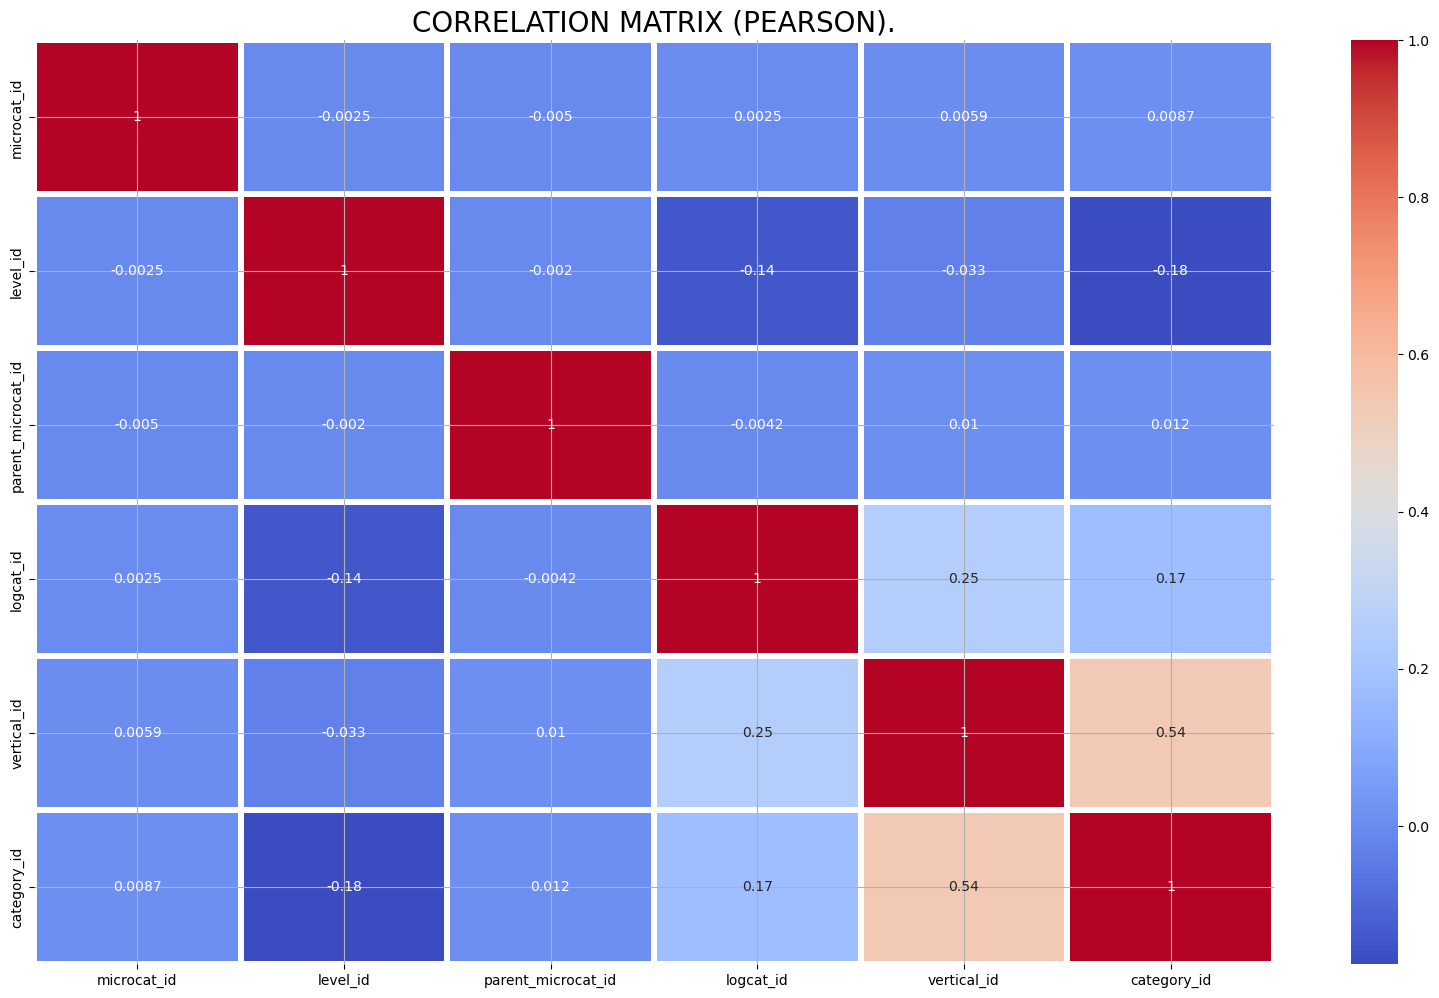

In [37]:
fig, ax = plt.subplots(figsize=(20,12))
plt.title('CORRELATION MATRIX (PEARSON).', fontsize=20)
sns.heatmap(categories.corr(), annot=True, cmap="coolwarm",  fmt='.2g', linewidth=4)
plt.grid(True);

In [9]:
#|-- adv_campaign_id: id рекламной компании 
#|-- start_date: date дата начала рекламной компании 
#|-- end_date: date дата завершения рекламной компании
#|-- goal_cost: цена за клик на рекламу
#|-- goal_budget: общий бюджет рекламной компании
#|-- logcat_id: id логической категории товаров из рекламной кампании
#|-- location_ids: id локации, на которую рекламная компания распространяется 

print(campaigns.head())
print('**********************************')
print(campaigns.describe())
print('**********************************')
print(campaigns.isnull().sum())
print('**********************************')
print(campaigns.info())

   adv_campaign_id  start_date    end_date  goal_cost  goal_budget  \
0             2153  2024-09-21  2024-10-02   6.661659  9429.056096   
1             3103  2024-09-10  2024-09-16   2.853378  3844.482933   
2             2816  2024-09-10  2024-09-17   3.058230  1455.156612   
3             3603  2024-09-10  2024-09-16   4.395015  2592.232475   
4             1328  2024-09-10  2024-09-16   3.891329  2836.139672   

   location_id  logcat_id  
0           70         59  
1           30         40  
2           56         65  
3           30         50  
4           30         51  
**********************************
       adv_campaign_id    goal_cost    goal_budget  location_id    logcat_id
count       4031.00000  4031.000000    4031.000000  4031.000000  4031.000000
mean        2099.56512     5.242840    7113.443134    39.466882    40.219052
std         1213.41340     3.547009   14102.599591    21.446496    18.289209
min            1.00000     0.950574       6.702396     1.000000     

   adv_campaign_id start_date   end_date  goal_cost  goal_budget  location_id  \
0             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   
1             3103 2024-09-10 2024-09-16   2.853378  3844.482933           30   
2             2816 2024-09-10 2024-09-17   3.058230  1455.156612           56   
3             3603 2024-09-10 2024-09-16   4.395015  2592.232475           30   
4             1328 2024-09-10 2024-09-16   3.891329  2836.139672           30   

   logcat_id  
0         59  
1         40  
2         65  
3         50  
4         51  
**********************************
       adv_campaign_id                     start_date  \
count       4031.00000                           4031   
mean        2099.56512  2024-09-09 05:43:39.399652864   
min            1.00000            2024-05-13 00:00:00   
25%         1049.50000            2024-09-09 00:00:00   
50%         2103.00000            2024-09-12 00:00:00   
75%         3152.50000            2024-09-17 0

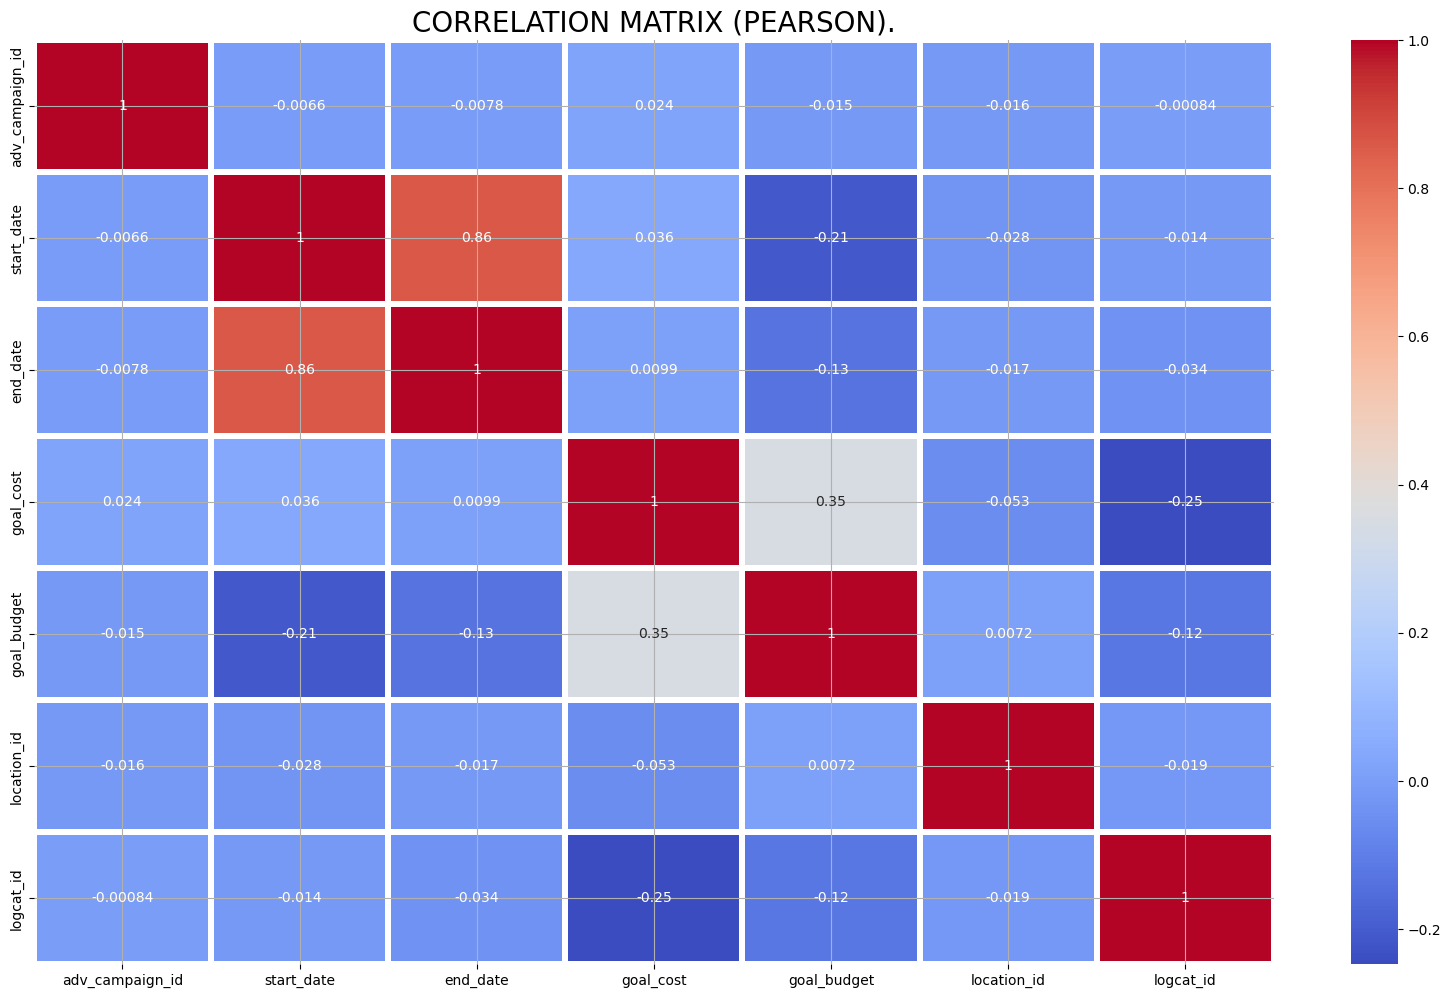

In [47]:
# Приведение типов
campaigns["adv_campaign_id"] = campaigns["adv_campaign_id"].astype('int16')
campaigns['start_date']=pd.to_datetime(campaigns['start_date'])
campaigns['end_date']=pd.to_datetime(campaigns['end_date'])
campaigns["location_id"] = campaigns["location_id"].astype('int8')
campaigns["logcat_id"] = campaigns["logcat_id"].astype('int8')

print(campaigns.head())
print('**********************************')
print(campaigns.describe())
print('**********************************')
print(campaigns.info())
print('**********************************')
fig, ax = plt.subplots(figsize=(20,12))
plt.title('CORRELATION MATRIX (PEARSON).', fontsize=20)
sns.heatmap(campaigns.corr(), annot=True, cmap="coolwarm",  fmt='.2g', linewidth=4)
plt.grid(True);

In [53]:
gc.collect()

9295

In [11]:
# JOIN датасетов
merge_df_1 = pd.merge(train, campaigns, on='adv_campaign_id', how='left')

In [13]:
merge_df = pd.merge(merge_df_1, categories, on='logcat_id', how='left')

MemoryError: Unable to allocate 1.34 TiB for an array with shape (183906839327,) and data type int64

In [15]:
#print(merge_df_1.info())
print('**********************************')
print(merge_df.head())
print('**********************************')
print(campaigns.isnull().sum())

**********************************


NameError: name 'merge_df' is not defined

<Axes: xlabel='ads_duration', ylabel='goal_cost'>

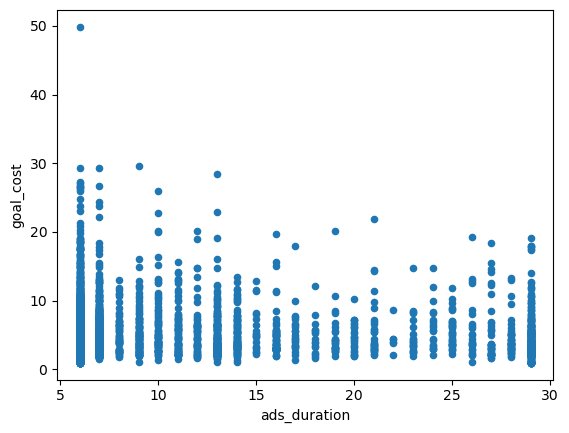

In [43]:
##### ПРОВЕРКА ФИЧ №№№№№№№№№№№

# Смотрим campaigns
campaigns.start_date = pd.to_datetime(campaigns.start_date)
campaigns.end_date = pd.to_datetime(campaigns.end_date)
campaigns['ads_duration'] = (campaigns.end_date - campaigns.start_date).dt.days
campaigns.plot.scatter(x='ads_duration', y='goal_cost')

<Axes: xlabel='logcat_id', ylabel='goal_budget'>

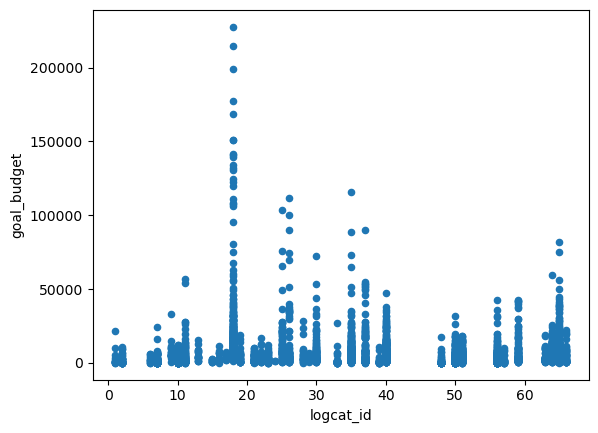

In [13]:
campaigns.plot.scatter(x='logcat_id', y='goal_budget')

In [ ]:
**Выводы:** длительность рекламы и ее направление не критично влияет на стоимость - есть просто дорогая и дешевая реклама

<Axes: ylabel='Frequency'>

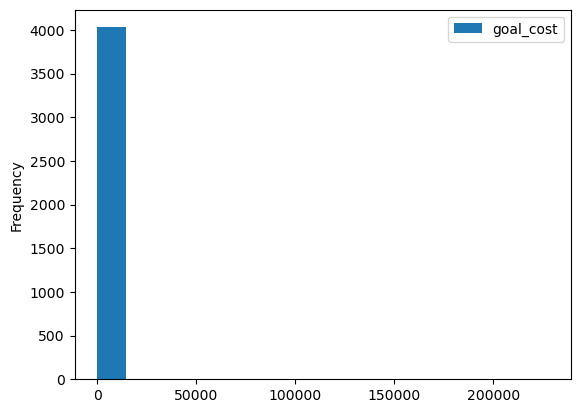

In [25]:
campaigns.plot.hist(column='goal_cost', bins=16)

<Axes: ylabel='Frequency'>

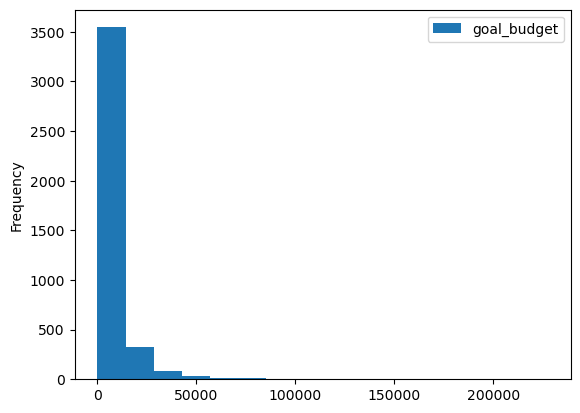

In [27]:
campaigns.plot.hist(column='goal_budget', bins=16)

In [29]:
campaigns[campaigns['goal_budget'] > 100000].sort_values(by='goal_budget', ascending=False)

,adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id
2238,2155,2024-09-17,2024-09-23,17.779562,227679.963364,46,18
3510,739,2024-09-18,2024-09-30,13.372574,214395.923782,30,18
3463,217,2024-08-20,2024-08-31,14.050671,198957.100367,30,18
2822,1535,2024-07-19,2024-07-26,14.826908,177596.710739,30,18
2821,2388,2024-07-22,2024-07-31,12.142784,168557.254495,46,18
2871,2456,2024-09-12,2024-09-20,13.029493,151036.590034,30,18
172,2656,2024-07-29,2024-08-05,13.373868,150649.439149,46,18
2347,1453,2024-08-08,2024-08-31,8.549973,141543.498925,47,18
2870,699,2024-09-12,2024-09-19,13.839542,140677.624582,46,18
3606,1674,2024-08-08,2024-08-31,8.307261,139413.638385,47,18


In [47]:
campaigns['price_per_day'] = campaigns.goal_budget / campaigns.ads_duration
campaigns.corr()

,adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,price_per_day,ads_duration
adv_campaign_id,1.000000,-0.006608,-0.007785,0.024338,-0.014800,-0.016127,-0.000839,-0.007470,-0.002262
start_date,-0.006608,1.000000,0.863427,0.035714,-0.209563,-0.028201,-0.014357,-0.149300,-0.260024
end_date,-0.007785,0.863427,1.000000,0.009941,-0.130941,-0.017183,-0.034059,-0.203493,0.262610
goal_cost,0.024338,0.035714,0.009941,1.000000,0.347853,-0.053019,-0.247352,0.371533,-0.049282
goal_budget,-0.014800,-0.209563,-0.130941,0.347853,1.000000,0.007195,-0.120989,0.863990,0.150198
location_id,-0.016127,-0.028201,-0.017183,-0.053019,0.007195,1.000000,-0.018685,-0.006791,0.021050
logcat_id,-0.000839,-0.014357,-0.034059,-0.247352,-0.120989,-0.018685,1.000000,-0.111028,-0.037731
price_per_day,-0.007470,-0.149300,-0.203493,0.371533,0.863990,-0.006791,-0.111028,1.000000,-0.103938
ads_duration,-0.002262,-0.260024,0.262610,-0.049282,0.150198,0.021050,-0.037731,-0.103938,1.000000


In [53]:
campaings_cat = campaigns.merge(categories, on='logcat_id')
print(campaings_cat.head())

   adv_campaign_id start_date   end_date  goal_cost  goal_budget  location_id  \
0             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   
1             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   
2             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   
3             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   
4             2153 2024-09-21 2024-10-02   6.661659  9429.056096           70   

   logcat_id  price_per_day  ads_duration  microcat_id  level_id  \
0         59     857.186918            11        25237       4.0   
1         59     857.186918            11        41723       4.0   
2         59     857.186918            11        18532       4.0   
3         59     857.186918            11         6006       3.0   
4         59     857.186918            11        37286       4.0   

   parent_microcat_id  vertical_id  category_id  
0              6006.0          8.0          5.0  
1   

<Axes: xlabel='dow'>

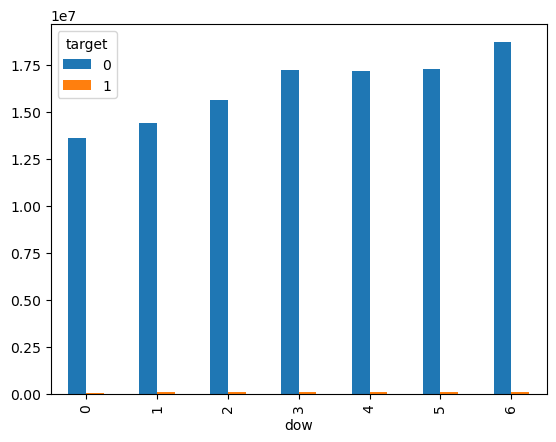

In [55]:
train['dow'] = train['event_date'].dt.weekday
count_data = train.groupby(['dow', 'target']).size().unstack(fill_value=0)
count_data.plot(kind='bar')

In [57]:
train[train['dow'] == 6]['target'].value_counts()

target
0    18733310
1      103418
Name: count, dtype: int64

In [59]:
train[train['dow'] == 0]['target'].value_counts()

target
0    13609760
1       69815
Name: count, dtype: int64

<Axes: xlabel='platform_id'>

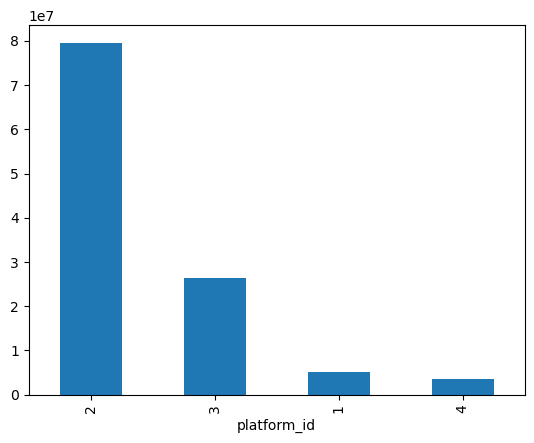

In [61]:
train['platform_id'].value_counts().plot.bar()

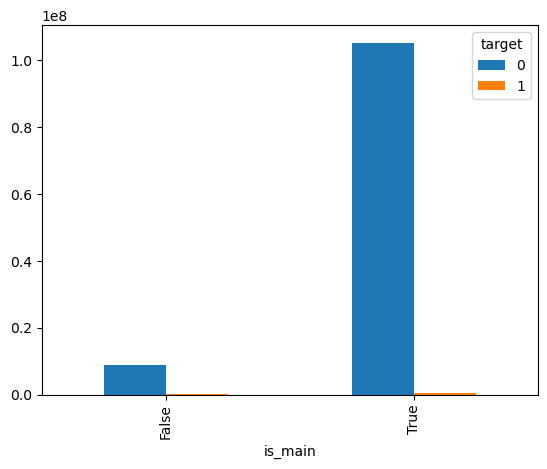

In [63]:
count_data = train.groupby(['is_main', 'target']).size().unstack(fill_value=0).plot.bar()

[0 1]
